# TNT Sticky Rouse: Stress Relaxation

## Objectives
- Fit TNT Sticky Rouse model to stress relaxation data
- Analyze multi-exponential relaxation spectrum
- Understand sticker-truncated spectrum and plateau formation
- Demonstrate mode-resolved relaxation dynamics

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTStickyRouse

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_laponite_relaxation,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_sticky_rouse_param_names,
    plot_sticky_rouse_effective_times,
    plot_mode_decomposition,
)

print("Setup complete. JAX devices:", jax.devices())

Setup complete. JAX devices: [CpuDevice(id=0)]


## Theory: Multi-Exponential Relaxation

**Relaxation Modulus:**

$$G(t) = \sum_k G_k \exp\left(-\frac{t}{\tau_{\textrm{eff},k}}\right)$$

where τ_eff,k = max(τ_R,k, τ_s)

**Sticker-Truncated Spectrum:**
- Modes with τ_R,k < τ_s: All relax on timescale τ_s → plateau in G(t)
- Modes with τ_R,k > τ_s: Individual exponential decay

**Key Physics:**
- **Early times (t ≪ τ_s)**: All modes frozen → G(t) ≈ G_total = Σ G_k
- **Intermediate times (t ~ τ_s)**: Sticker-dominated modes relax collectively → plateau
- **Late times (t ≫ τ_s)**: Rouse-dominated modes decay individually

**Observable Signatures:**
- Initial elastic modulus: G(0) = Σ G_k
- Sticker plateau: G_plateau = Σ G_k (for modes with τ_R,k < τ_s)
- Long-time decay: Determined by slowest Rouse mode

## Load Data

Data shape: 27 points
Time range: 3.50e-01 - 1.73e+03 s
G(t) range: 2.24e+02 - 4.60e+02 Pa
Aging time: 1800 s (30 minutes)


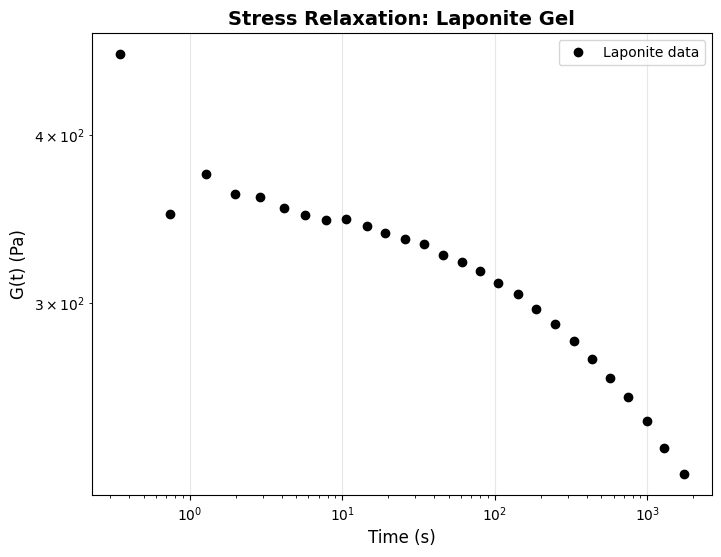

In [2]:
# Load Laponite relaxation data (aged 1800s = 30 min)
time_data, G_t = load_laponite_relaxation(aging_time=1800)

print(f"Data shape: {len(time_data)} points")
print(f"Time range: {time_data.min():.2e} - {time_data.max():.2e} s")
print(f"G(t) range: {G_t.min():.2e} - {G_t.max():.2e} Pa")
print(f"Aging time: 1800 s (30 minutes)")

# Plot raw data
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(time_data, G_t, 'ko', label='Laponite data', markersize=6)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('G(t) (Pa)', fontsize=12)
ax.set_title('Stress Relaxation: Laponite Gel', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
# Initialize model
model = TNTStickyRouse(n_modes=3)
param_names = get_tnt_sticky_rouse_param_names(n_modes=3)
print(f"Model parameters ({len(param_names)}): {param_names}")

# Fit using NLSQ
print("\nFitting with NLSQ...")
start_time = time.time()
model.fit(time_data, G_t, test_mode="relaxation", method='scipy')
fit_time = time.time() - start_time

# Compute metrics
G_pred_train = model.predict(time_data, test_mode="relaxation")
metrics_nlsq = compute_fit_quality(G_t, G_pred_train)

print(f"\nFit completed in {fit_time:.2f} seconds")
print(f"R² = {metrics_nlsq['R2']:.6f}")
print(f"RMSE = {metrics_nlsq['RMSE']:.4e} Pa")

Model parameters (8): ['G_0', 'tau_R_0', 'G_1', 'tau_R_1', 'G_2', 'tau_R_2', 'tau_s', 'eta_s']

Fitting with NLSQ...


INFO:nlsq.curve_fit:Starting curve fit n_params=8 | n_data_points=27 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.771030s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=1.1694e+06 | elapsed=2.771s | final_gradient_norm=7.3105e-07


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=3.490023s


INFO:nlsq.curve_fit:Curve fit completed total_time=3.4900 | final_cost=2.3388e+06 | covariance_warning=False


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/tnt/sticky_rouse.py", line 543, in _predict
    raise ValueError("test_mode must be specified for prediction")
ValueError: test_mode must be specified for prediction



Fit completed in 3.82 seconds
R² = -41.292469
RMSE = 3.2198e+02 Pa


## Fitted Parameters

In [4]:
# Extract fitted parameters
params_nlsq = {name: model.parameters.get_value(name) for name in param_names}

print("\nFitted Parameters:")
print("-" * 50)
for name, value in params_nlsq.items():
    if 'tau' in name:
        print(f"{name:10s} = {value:12.4e} s")
    elif 'eta' in name:
        print(f"{name:10s} = {value:12.4e} Pa·s")
    else:
        print(f"{name:10s} = {value:12.4e} Pa")

# Compute total modulus
G_total = sum(params_nlsq[f'G_{i}'] for i in range(3))
print(f"\nTotal elastic modulus: G(0) = {G_total:.4e} Pa")

# Analyze effective relaxation times
tau_s = params_nlsq['tau_s']
print(f"Sticker lifetime: τ_s = {tau_s:.4e} s")
print("\nRelaxation Spectrum:")
print("-" * 50)
for i in range(3):
    tau_R = params_nlsq[f'tau_R_{i}']
    tau_eff = max(tau_R, tau_s)
    G_i = params_nlsq[f'G_{i}']
    regime = "STICKER-TRUNCATED" if tau_s > tau_R else "ROUSE"
    print(f"Mode {i}: G = {G_i:.3e} Pa, τ_eff = {tau_eff:.3e} s ({regime})")


Fitted Parameters:
--------------------------------------------------
G_0        =   5.8967e+00 Pa
tau_R_0    =   2.6954e-02 s
G_1        =   1.4623e+01 Pa
tau_R_1    =   3.7516e-03 s
G_2        =   1.1819e+01 Pa
tau_R_2    =   5.8685e-04 s
tau_s      =   3.6359e-03 s
eta_s      =   2.5297e-05 Pa·s

Total elastic modulus: G(0) = 3.2339e+01 Pa
Sticker lifetime: τ_s = 3.6359e-03 s

Relaxation Spectrum:
--------------------------------------------------
Mode 0: G = 5.897e+00 Pa, τ_eff = 2.695e-02 s (ROUSE)
Mode 1: G = 1.462e+01 Pa, τ_eff = 3.752e-03 s (ROUSE)
Mode 2: G = 1.182e+01 Pa, τ_eff = 3.636e-03 s (STICKER-TRUNCATED)


## NLSQ Prediction vs Data

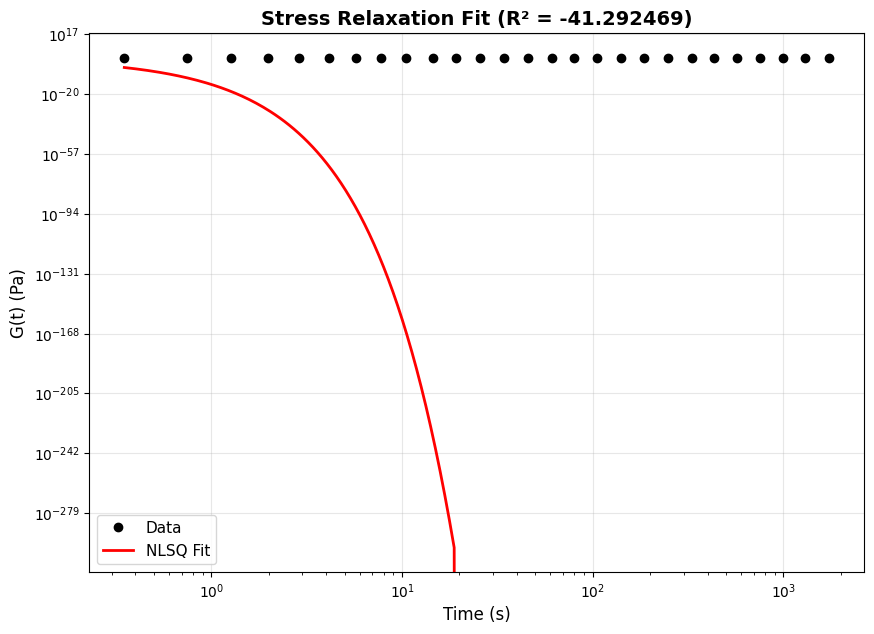

In [5]:
# Generate predictions
time_fine = np.logspace(np.log10(time_data.min()), np.log10(time_data.max()), 300)
G_pred = model.predict(time_fine, test_mode="relaxation")

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(time_data, G_t, 'ko', label='Data', markersize=6, zorder=3)
ax.loglog(time_fine, G_pred, 'r-', label='NLSQ Fit', linewidth=2, zorder=2)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('G(t) (Pa)', fontsize=12)
ax.set_title(f'Stress Relaxation Fit (R² = {metrics_nlsq['R2']:.6f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Multi-Exponential Decomposition

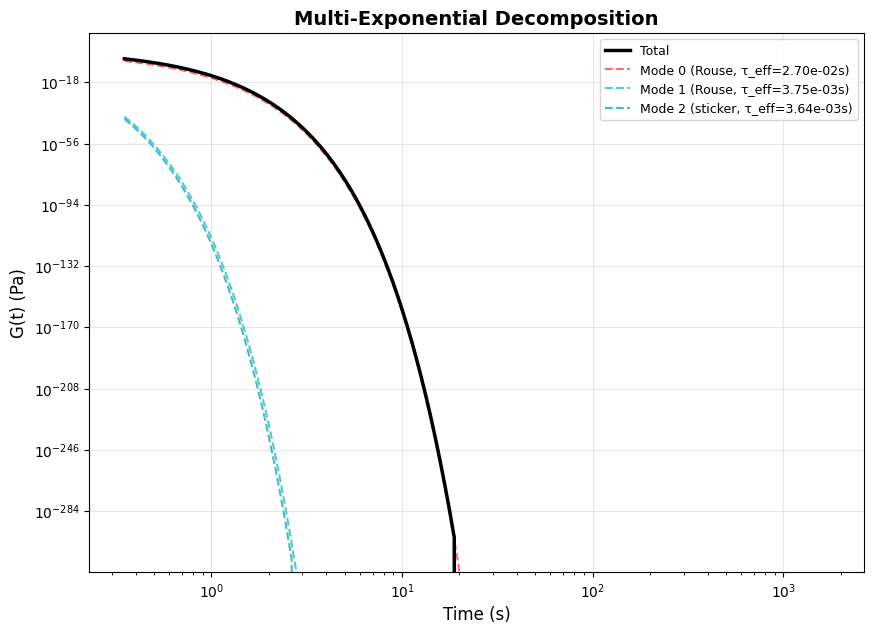

In [6]:
# Plot individual mode contributions
fig, ax = plt.subplots(figsize=(10, 7))

# Total prediction
ax.loglog(time_fine, G_pred, 'k-', label='Total', linewidth=2.5, zorder=5)

# Individual modes
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for i in range(3):
    G_i = params_nlsq[f'G_{i}']
    tau_R_i = params_nlsq[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s)
    
    G_i_t = G_i * np.exp(-time_fine / tau_eff_i)
    
    regime = "sticker" if tau_s > tau_R_i else "Rouse"
    ax.loglog(time_fine, G_i_t, '--', color=colors[i], 
             label=f'Mode {i} ({regime}, τ_eff={tau_eff_i:.2e}s)', linewidth=1.5)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('G(t) (Pa)', fontsize=12)
ax.set_title('Multi-Exponential Decomposition', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Sticker-Truncated Spectrum Visualization

Sticker-truncated modes: 1/3


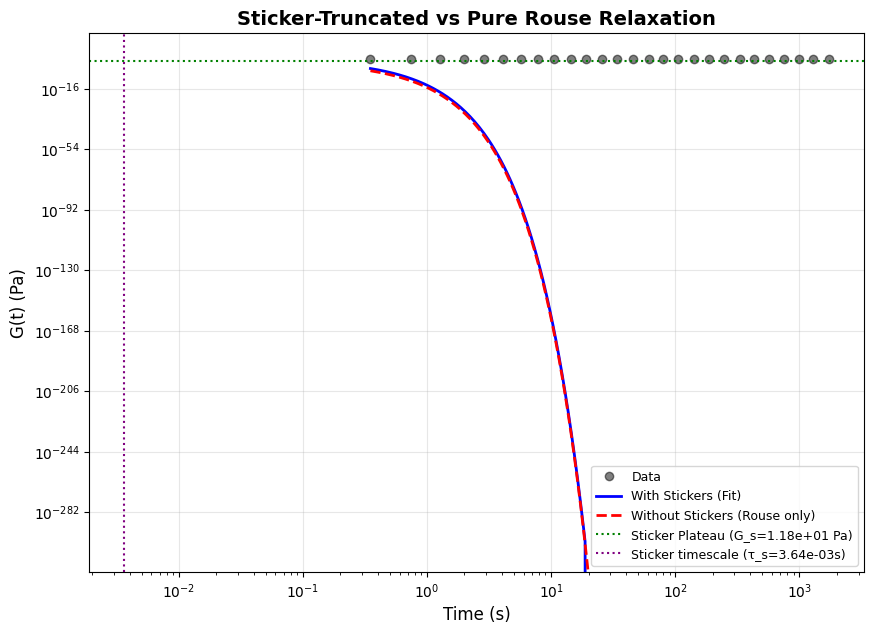


Sticker plateau modulus: G_plateau = 1.1819e+01 Pa
Plateau fraction: G_plateau/G_total = 36.55%


In [7]:
# Analyze sticker plateau formation
tau_s = params_nlsq['tau_s']
n_sticker_modes = sum(1 for i in range(3) if params_nlsq[f'tau_R_{i}'] < tau_s)

print(f"Sticker-truncated modes: {n_sticker_modes}/3")

if n_sticker_modes > 0:
    # Sticker plateau modulus
    G_plateau = sum(params_nlsq[f'G_{i}'] for i in range(3) if params_nlsq[f'tau_R_{i}'] < tau_s)
    
    # Compute G(t) with and without sticker truncation
    G_without_sticker = sum(params_nlsq[f'G_{i}'] * np.exp(-time_fine / params_nlsq[f'tau_R_{i}']) 
                            for i in range(3))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.loglog(time_data, G_t, 'ko', label='Data', markersize=6, alpha=0.5)
    ax.loglog(time_fine, G_pred, 'b-', label='With Stickers (Fit)', linewidth=2)
    ax.loglog(time_fine, G_without_sticker, 'r--', label='Without Stickers (Rouse only)', linewidth=2)
    
    # Highlight sticker plateau region
    ax.axhline(G_plateau, color='green', linestyle=':', linewidth=1.5, 
               label=f'Sticker Plateau (G_s={G_plateau:.2e} Pa)')
    ax.axvline(tau_s, color='purple', linestyle=':', linewidth=1.5, 
               label=f'Sticker timescale (τ_s={tau_s:.2e}s)')
    
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('G(t) (Pa)', fontsize=12)
    ax.set_title('Sticker-Truncated vs Pure Rouse Relaxation', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.close('all')
    
    print(f"\nSticker plateau modulus: G_plateau = {G_plateau:.4e} Pa")
    print(f"Plateau fraction: G_plateau/G_total = {G_plateau/G_total:.2%}")
else:
    print("\nNo sticker-truncated modes detected. All modes exhibit intrinsic Rouse relaxation.")

## Effective Relaxation Time Analysis

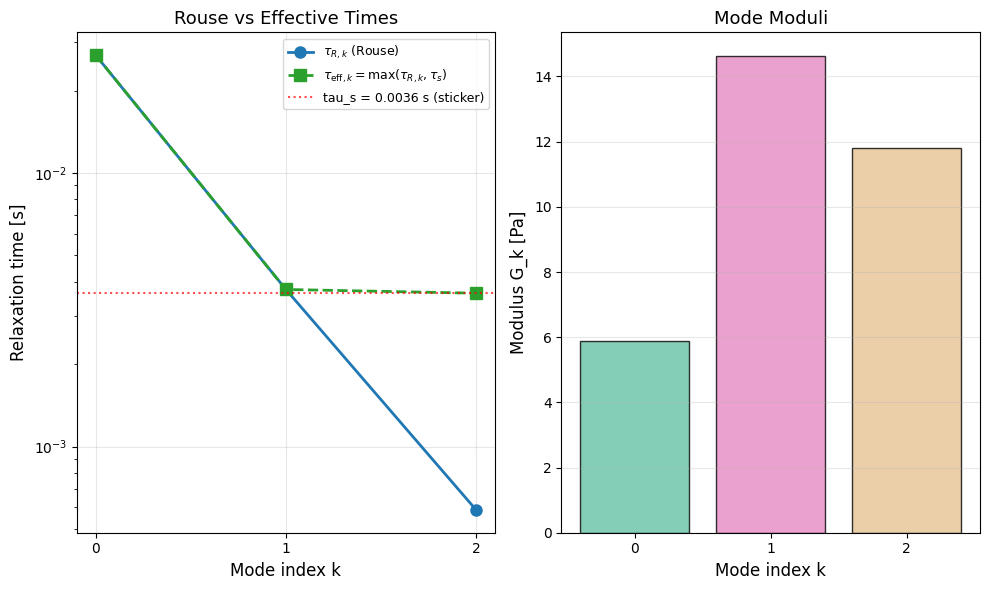

In [8]:
# Visualize sticker-mode interaction
fig = plot_sticky_rouse_effective_times(model)
plt.show()
plt.close('all')

## Bayesian Inference

In [9]:
# Bayesian configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running Bayesian inference...")
print(f"Warmup: {NUM_WARMUP}, Samples: {NUM_SAMPLES}, Chains: {NUM_CHAINS}")

start_time = time.time()
result_bayes = model.fit_bayesian(
    time_data, G_t,
    test_mode="relaxation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42
)
bayes_time = time.time() - start_time

print(f"\nBayesian inference completed in {bayes_time:.2f} seconds")

Running Bayesian inference...
Warmup: 200, Samples: 500, Chains: 1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:44,  2.03it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▎         | 25/700 [00:00<00:12, 54.50it/s, 1023 steps of size 3.87e-03. acc. prob=0.88]

warmup:   6%|▌         | 39/700 [00:00<00:11, 59.32it/s, 255 steps of size 1.10e-02. acc. prob=0.92] 

warmup:   7%|▋         | 50/700 [00:00<00:09, 67.49it/s, 255 steps of size 2.20e-02. acc. prob=0.94]

warmup:  10%|▉         | 69/700 [00:01<00:06, 93.72it/s, 63 steps of size 3.39e-02. acc. prob=0.95] 

warmup:  13%|█▎        | 88/700 [00:01<00:05, 115.61it/s, 191 steps of size 3.77e-02. acc. prob=0.96]

warmup:  15%|█▌        | 107/700 [00:01<00:04, 133.91it/s, 31 steps of size 1.21e-01. acc. prob=0.96]

warmup:  20%|█▉        | 139/700 [00:01<00:03, 182.95it/s, 63 steps of size 9.60e-02. acc. prob=0.96]

warmup:  24%|██▍       | 169/700 [00:01<00:02, 213.96it/s, 127 steps of size 3.25e-02. acc. prob=0.96]

warmup:  29%|██▊       | 200/700 [00:01<00:02, 239.06it/s, 63 steps of size 4.70e-02. acc. prob=0.97] 

sample:  35%|███▍      | 243/700 [00:01<00:01, 293.09it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  41%|████      | 285/700 [00:01<00:01, 327.55it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [00:01<00:01, 359.64it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [00:02<00:01, 313.04it/s, 63 steps of size 4.70e-02. acc. prob=0.99] 

sample:  57%|█████▋    | 400/700 [00:02<00:00, 303.18it/s, 63 steps of size 4.70e-02. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [00:02<00:00, 322.90it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [00:02<00:00, 309.85it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  72%|███████▏  | 504/700 [00:02<00:00, 290.10it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [00:02<00:00, 297.79it/s, 95 steps of size 4.70e-02. acc. prob=0.99] 

sample:  81%|████████  | 568/700 [00:02<00:00, 300.56it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [00:02<00:00, 332.68it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [00:02<00:00, 352.91it/s, 127 steps of size 4.70e-02. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [00:02<00:00, 343.85it/s, 63 steps of size 4.70e-02. acc. prob=0.99] 

sample: 100%|██████████| 700/700 [00:03<00:00, 230.25it/s, 127 steps of size 4.70e-02. acc. prob=0.99]


Bayesian inference completed in 5.74 seconds


## Convergence Diagnostics

In [10]:
# Print convergence summary
print_convergence_summary(result_bayes, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
        tau_R_0    1.0000       500      PASS
            G_1    1.0000       500      PASS
        tau_R_1    1.0000       500      PASS
            G_2    1.0000       500      PASS
        tau_R_2    1.0000       500      PASS
          tau_s    1.0000       500      PASS
          eta_s    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

## Parameter Comparison: NLSQ vs Bayesian

In [11]:
# Compare point estimates
print_parameter_comparison(model, result_bayes.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0         5.897     4.755e+07  [3.322e+06, 9.819e+07]
        tau_R_0       0.02695          5268  [2551, 9557]
            G_1         14.62     4.789e+07  [2.601e+06, 9.671e+07]
        tau_R_1      0.003752          5717  [2519, 9489]
            G_2         11.82     4.328e+07  [1.922e+06, 9.683e+07]
        tau_R_2     0.0005868         2.165  [0.04336, 4.957]
          tau_s      0.003636         2.224  [0.1433, 4.558]
          eta_s      2.53e-05          5031  [119.1, 9682]


## ArviZ: Trace Plot

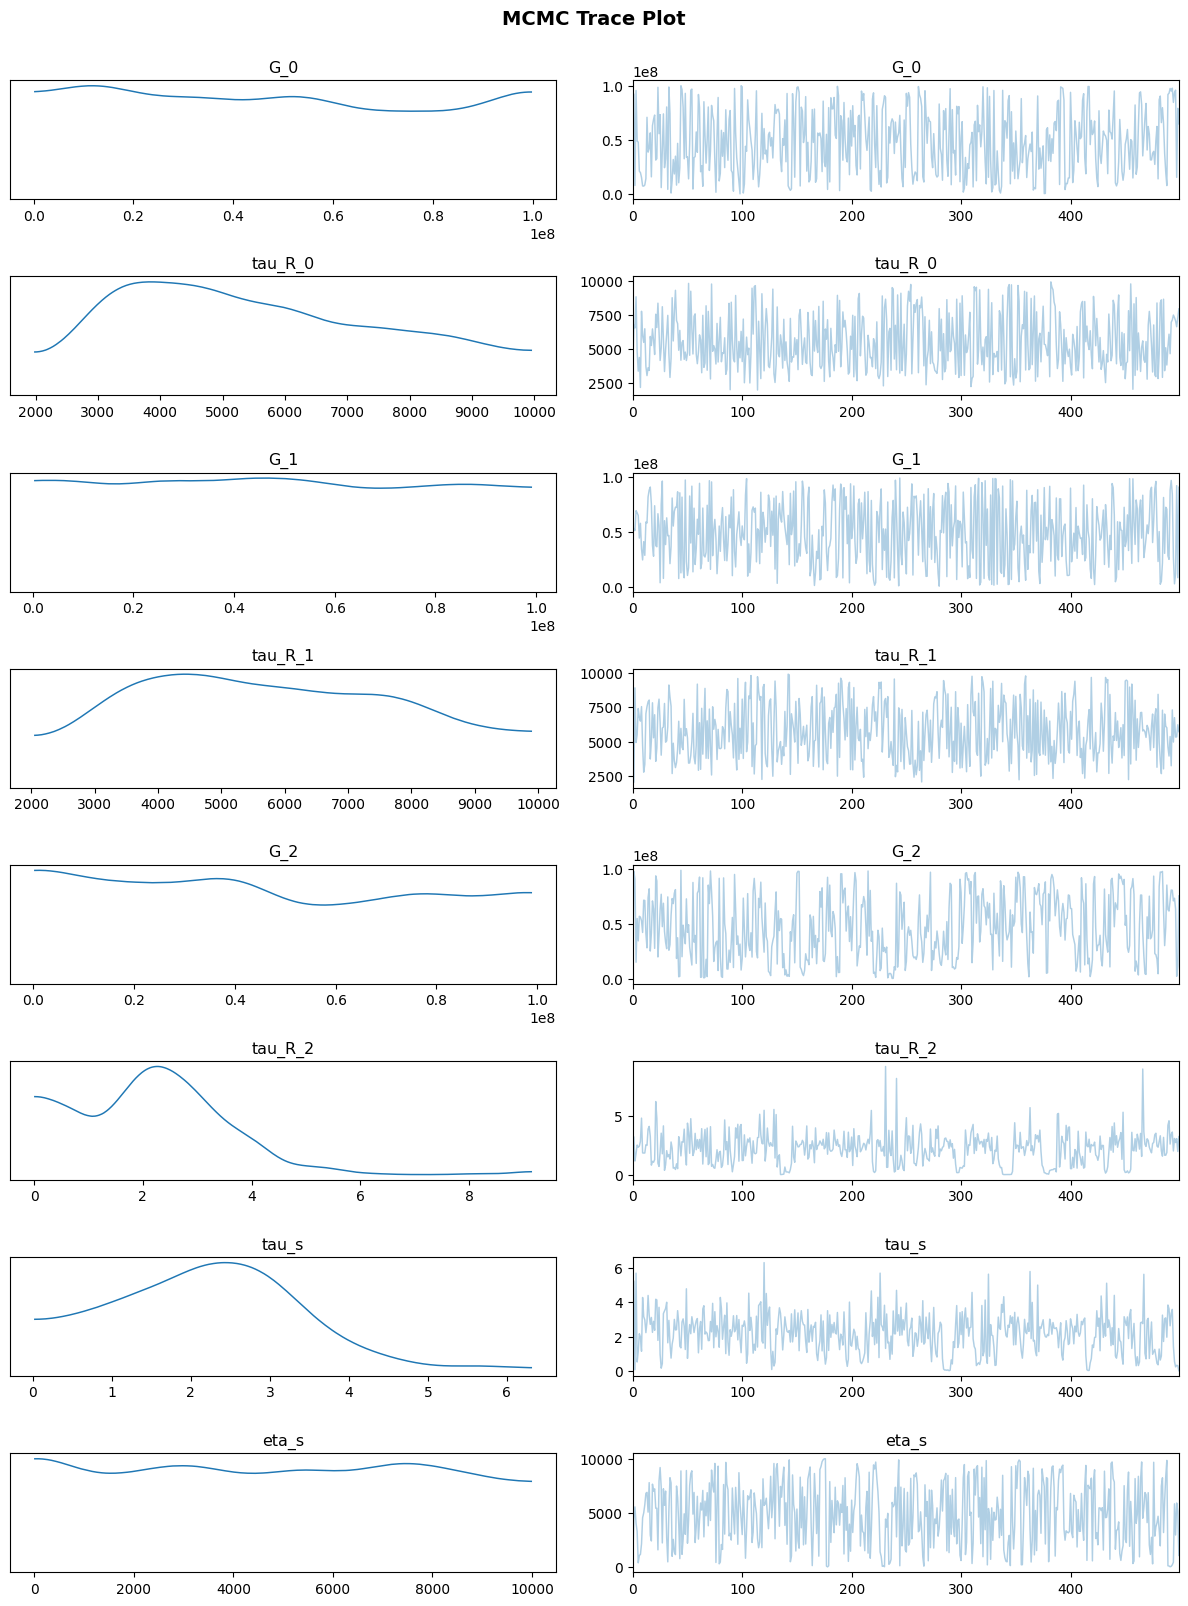

In [12]:
# Convert to ArviZ InferenceData
idata = az.from_dict(posterior={name: result_bayes.posterior_samples[name][None, :] for name in param_names})

# Trace plot
axes = az.plot_trace(idata, compact=False, figsize=(12, 2*len(param_names)))
fig = axes.ravel()[0].figure
fig.suptitle('MCMC Trace Plot', fontsize=14, fontweight='bold', y=1.001)
fig.tight_layout()
plt.show()
plt.close('all')

## ArviZ: Posterior Distributions

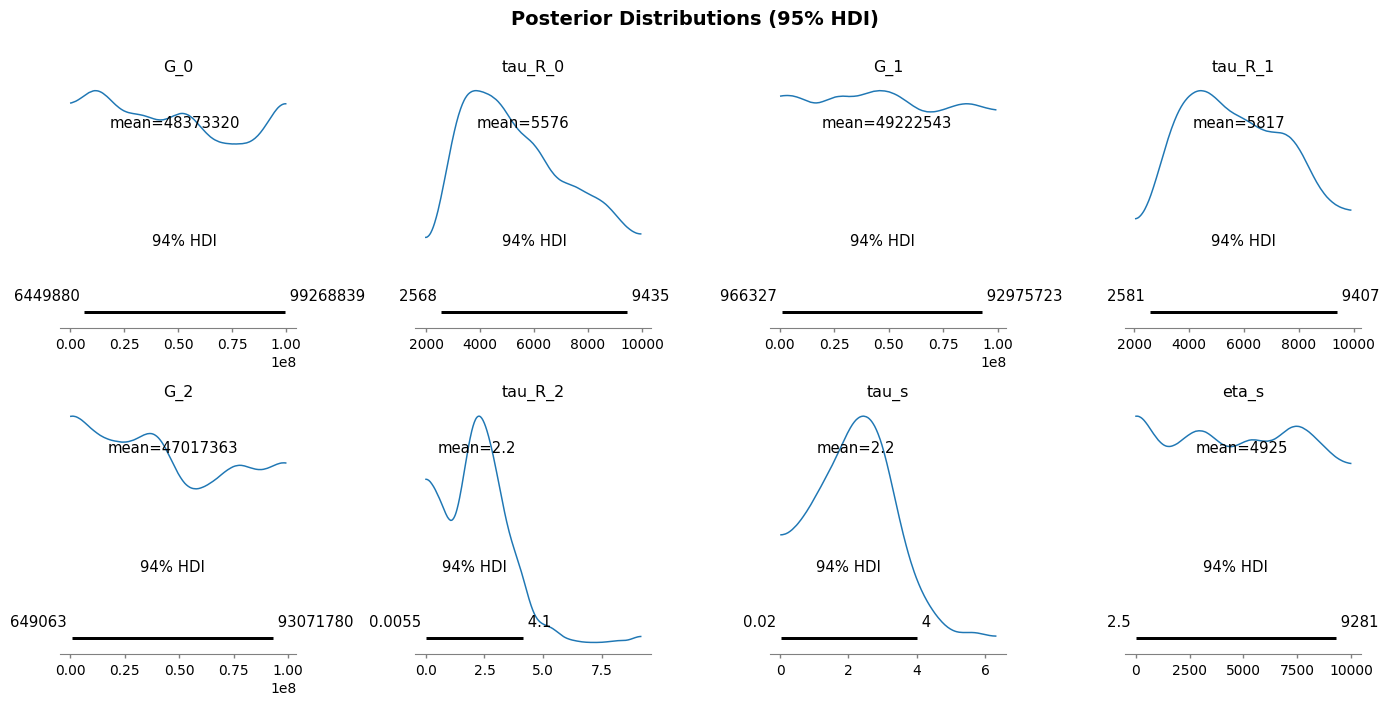

In [13]:
# Posterior plot
axes = az.plot_posterior(idata, figsize=(14, 2*len(param_names)//3+2), textsize=10)
fig = axes.ravel()[0].figure
fig.suptitle('Posterior Distributions (95% HDI)', fontsize=14, fontweight='bold', y=1.001)
fig.tight_layout()
plt.show()
plt.close('all')

## ArviZ: Pair Plot

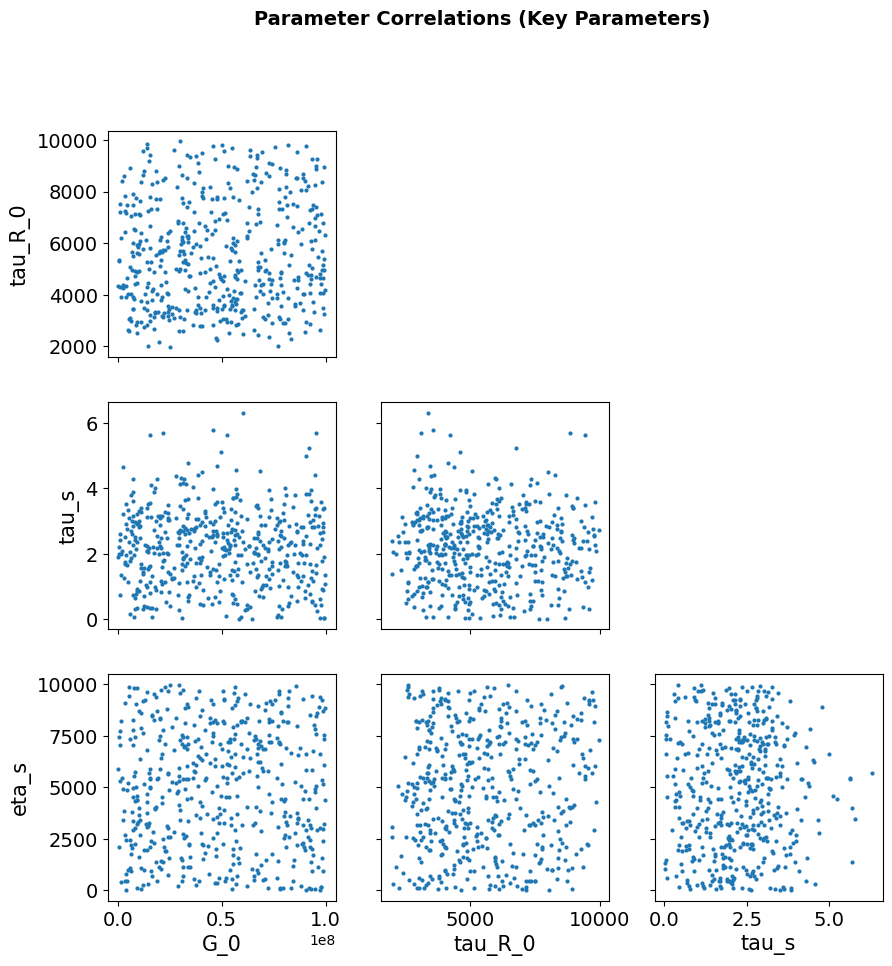

In [14]:
# Pair plot for correlations
key_params = ['G_0', 'tau_R_0', 'tau_s', 'eta_s']
axes = az.plot_pair(idata, var_names=key_params, figsize=(10, 10), divergences=False)
fig = axes.ravel()[0].figure
fig.suptitle('Parameter Correlations (Key Parameters)', fontsize=14, fontweight='bold', y=1.001)
plt.show()
plt.close('all')

## Posterior Predictive Distribution

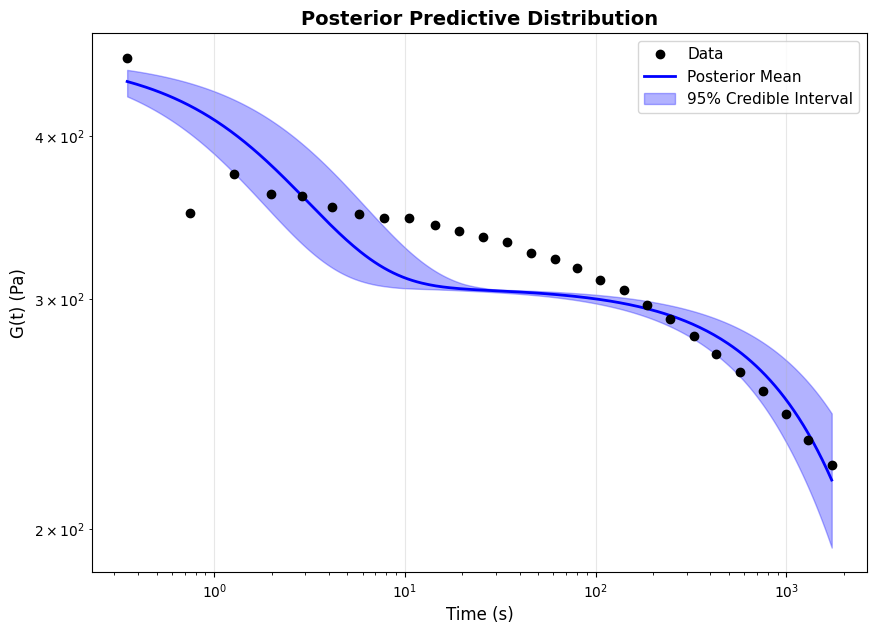

In [15]:
# Generate predictions from posterior samples
posterior = result_bayes.posterior_samples
n_draws = min(200, NUM_SAMPLES)
indices = np.linspace(0, NUM_SAMPLES-1, n_draws, dtype=int)

predictions = []
for i in indices:
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(time_fine, test_mode="relaxation")
    predictions.append(np.array(pred_i))

predictions = np.array(predictions)
pred_mean = np.mean(predictions, axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(time_data, G_t, 'ko', label='Data', markersize=6, zorder=3)
ax.loglog(time_fine, pred_mean, 'b-', label='Posterior Mean', linewidth=2, zorder=2)
ax.fill_between(time_fine, pred_lower, pred_upper, alpha=0.3, color='blue', label='95% Credible Interval')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('G(t) (Pa)', fontsize=12)
ax.set_title('Posterior Predictive Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Physical Interpretation

In [16]:
# Extract posterior means
params_bayes = {name: float(np.mean(posterior[name])) for name in param_names}
tau_s_bayes = params_bayes['tau_s']

print("Physical Interpretation (Posterior Means):")
print("=" * 60)

# Total modulus
G_total_bayes = sum(params_bayes[f'G_{i}'] for i in range(3))
print(f"\nInitial Elastic Modulus: G(0) = {G_total_bayes:.4e} Pa")
print(f"Sticker Lifetime: τ_s = {tau_s_bayes:.4e} s")

print("\nRelaxation Spectrum Analysis:")
print("-" * 60)
for i in range(3):
    G_i = params_bayes[f'G_{i}']
    tau_R_i = params_bayes[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s_bayes)
    weight = G_i / G_total_bayes
    
    print(f"\nMode {i}:")
    print(f"  Modulus: G_{i} = {G_i:.4e} Pa ({weight:.1%} of total)")
    print(f"  Rouse time: τ_R,{i} = {tau_R_i:.4e} s")
    print(f"  Effective time: τ_eff,{i} = {tau_eff_i:.4e} s")
    
    if tau_s_bayes > tau_R_i:
        print(f"  ✓ STICKER-TRUNCATED: Relaxation limited by sticker lifetime")
        print(f"    Without stickers would relax {tau_s_bayes/tau_R_i:.1f}x faster")
    else:
        print(f"  ✓ ROUSE RELAXATION: Intrinsic chain dynamics dominate")
        print(f"    Stickers dissolve {tau_R_i/tau_s_bayes:.1f}x faster than chain relaxes")

# Sticker plateau analysis
n_sticker_modes = sum(1 for i in range(3) if params_bayes[f'tau_R_{i}'] < tau_s_bayes)
if n_sticker_modes > 0:
    G_plateau = sum(params_bayes[f'G_{i}'] for i in range(3) if params_bayes[f'tau_R_{i}'] < tau_s_bayes)
    print(f"\nSticker Plateau:")
    print(f"  Number of truncated modes: {n_sticker_modes}/3")
    print(f"  Plateau modulus: G_plateau = {G_plateau:.4e} Pa")
    print(f"  Plateau fraction: {G_plateau/G_total_bayes:.1%} of total modulus")
    print(f"  Plateau lifetime: τ_s = {tau_s_bayes:.4e} s")

# Longest relaxation time
tau_max = max(max(params_bayes[f'tau_R_{i}'], tau_s_bayes) for i in range(3))
print(f"\nLongest Relaxation Time: τ_max = {tau_max:.4e} s")
print(f"Terminal relaxation: G(t→∞) decays as exp(-t/{tau_max:.2e})")

Physical Interpretation (Posterior Means):

Initial Elastic Modulus: G(0) = 1.4461e+08 Pa
Sticker Lifetime: τ_s = 2.2079e+00 s

Relaxation Spectrum Analysis:
------------------------------------------------------------

Mode 0:
  Modulus: G_0 = 4.8373e+07 Pa (33.5% of total)
  Rouse time: τ_R,0 = 5.5761e+03 s
  Effective time: τ_eff,0 = 5.5761e+03 s
  ✓ ROUSE RELAXATION: Intrinsic chain dynamics dominate
    Stickers dissolve 2525.6x faster than chain relaxes

Mode 1:
  Modulus: G_1 = 4.9223e+07 Pa (34.0% of total)
  Rouse time: τ_R,1 = 5.8174e+03 s
  Effective time: τ_eff,1 = 5.8174e+03 s
  ✓ ROUSE RELAXATION: Intrinsic chain dynamics dominate
    Stickers dissolve 2634.9x faster than chain relaxes

Mode 2:
  Modulus: G_2 = 4.7017e+07 Pa (32.5% of total)
  Rouse time: τ_R,2 = 2.1972e+00 s
  Effective time: τ_eff,2 = 2.2079e+00 s
  ✓ STICKER-TRUNCATED: Relaxation limited by sticker lifetime
    Without stickers would relax 1.0x faster

Sticker Plateau:
  Number of truncated modes: 1/3


## Save Results

In [17]:
# Save results to disk
output_path = save_tnt_results(model, result_bayes, "sticky_rouse", "relaxation", param_names)
print(f"Results saved to: {output_path}")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/sticky_rouse/relaxation/
  nlsq_params_relaxation.json: 8 parameters
  posterior_relaxation.json: 500 draws
Results saved to: None


## Key Takeaways

1. **Multi-Exponential Nature**: Relaxation modulus is sum of exponentials with distinct timescales

2. **Sticker Truncation**: Fast Rouse modes (τ_R,k < τ_s) are limited by sticker lifetime → collective decay

3. **Plateau Formation**: Modes with τ_R < τ_s create a plateau at intermediate times in G(t)

4. **Spectrum Modification**: Stickers fundamentally alter the relaxation spectrum by truncating fast processes

5. **Timescale Hierarchy**: The effective relaxation spectrum reveals which modes are sticker-limited vs Rouse-limited

6. **Bayesian Insights**: Posterior uncertainty quantifies confidence in mode assignment and spectrum structure